<a href="https://colab.research.google.com/github/elavens/Project/blob/main/resnet50for10epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

# Define paths for the dataset
data_dir = '/content/drive/MyDrive/data'
batch_size = 32

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate the sizes of train and test sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

In [4]:
# Split the dataset into train and test sets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Define the ResNet-50 model
class ResNet50Custom(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Custom, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

In [6]:
# Define the model and move it to the appropriate device (GPU if available)
num_classes = len(dataset.classes)
model = ResNet50Custom(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 318MB/s]


ResNet50Custom(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(train_loader)}")


Epoch [1/10] - Loss: 0.4624302749122892
Epoch [2/10] - Loss: 0.3286293457661356
Epoch [3/10] - Loss: 0.424743019257273
Epoch [4/10] - Loss: 0.2823147850377219
Epoch [5/10] - Loss: 0.19715892874768803
Epoch [6/10] - Loss: 0.19526665577931063
Epoch [7/10] - Loss: 0.19114616619689123
Epoch [8/10] - Loss: 0.13526384867727756
Epoch [9/10] - Loss: 0.14663053900003434
Epoch [10/10] - Loss: 0.1024330589388098


Test Accuracy: 87.92%
Precision: 0.90
Recall: 0.88
F1 Score: 0.88


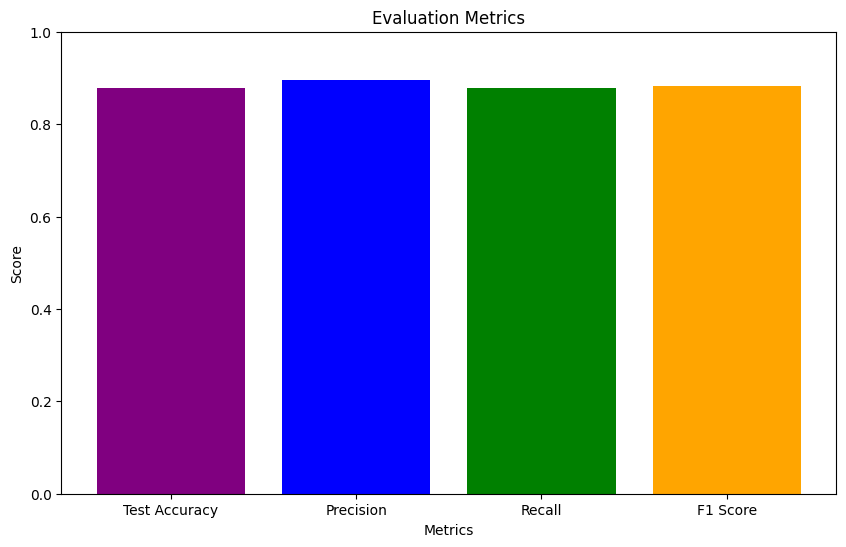

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# Evaluation
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plotting
scores = [accuracy, precision, recall, f1]
score_names = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(10, 6))
plt.bar(score_names, scores, color=['purple', 'blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1.0)  # Set the y-axis limit
plt.show()
